In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import LearningRateScheduler
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error
import csv

2024-08-13 14:20:53.141641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cita/modules/python/3.10.2/lib
2024-08-13 14:20:53.141703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# split the train and test data set 
# build a vanilla NN where the input is the 2-d density and the thing to predict is the 3-d density
# problem of supervised learning
# first we need to load the pandas dataframe and split it into training and test dataset

In [6]:
# now numpy_array is a 2-d array that has elements which are 2 element arrays containing the 2-d and 3-d density
# now we split the data
csv_file = '/home/ajain/cloudphinder/density_data_file'
df = pd.read_csv(csv_file, sep='\t')
numpy_array = df.to_numpy()
input_array = (numpy_array[:, 0].astype(float).reshape(-1))  # 2D densities
output_array = (numpy_array[:, 1].astype(float).reshape(-1))  # 3D densities

In [3]:

class Machine_learning_models:
    def __init__(self, input_dimension=None, output_dimension=None, estimators=None,random_state=None, layers=None, neuron_array=None):
        self.input = input_dimension
        self.output = output_dimension
        self.estimators= estimators
        self.random_state= random_state
        self.layers= layers
        self.neurons= neuron_array
        self.model = self.build_model()
        
    def build_model(self):
        if(len(self.neurons)==self.layers):
            model = Sequential()
            model.add(Dense(16, activation='relu', input_shape=(self.input,)))
            for layer in range(self.layers):
                model.add(Dense(self.neurons[layer], activation='relu'))
                
            model.add(Dense(self.output,))
            model.compile(optimizer='adam', 
            loss='mean_squared_error', 
            metrics=[MeanAbsoluteError()])
            return model
    
        else:
            print("number of layers and the neuron array length does not match , check it once!!")
    
    def scheduler(self, epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * 0.9
    
    def model_fit(self, train_x, train_y, epochs, batch_size, validation_split):
        lr_scheduler = LearningRateScheduler(self.scheduler)
        history = self.model.fit(train_x, train_y, 
                                 epochs=epochs, 
                                 batch_size=batch_size, 
                                 validation_split=validation_split, 
                                 callbacks=[lr_scheduler])
        loss= history.history['loss']
        val_loss= history.history['val_loss']
        epochs= range(1, len(loss)+1)
        plt.plot(epochs, loss, 'y', label= ' Training Loss' )
        plt.plot(epochs, val_loss, 'r', label= ' Validation Loss')
        plt.title('Traning and  Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        acc= history.history['mean_absolute_error']
        val_acc= history.history['val_mean_absolute_error']
        plt.plot(epochs, acc, 'y', label= ' Training MAE' )
        plt.plot(epochs, val_acc, 'r', label= ' Validation MAE')
        plt.title('Traning and  Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        
        
    def log_transformation(self, input_array):
        return np.log(input_array)

    def yeo_johnson_transform(self,data):
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data = pt.fit_transform(data.reshape(-1,1))
        return transformed_data
    
    # when the input data is the form of a gaussian apply standarization
    
    def standardization(self,input_array):
        mean= np.mean(input_array)
        st= np.std(input_array)
        x_trans= (input_array- mean)/st
        return x_trans , mean , st
    
    # when the data is not the form of a gaussian apply normalization
    
    def normalization(self,input_array):
        minimum= np.min(input_array) 
        delta= np.max(input_array)- np.min(input_array)
        x_trans= (input_array-minimum)/delta
        #print("min after normalizing the log quantity:", np.min(x_trans), "max after normalizing the log quantity:", np.max(x_trans))
        return x_trans.reshape(-1), delta, minimum
    
    
    def inverse_normalize(self,normalized_array, delta, minimum):
        X_retransformed= (normalized_array*delta)+ minimum
        #print("min after normalizing :", np.min( X_retransformed), "max after normalizing (should give max of log values):", np.max( X_retransformed))
        return  X_retransformed
    
    def inverse_standardization(self,standardized_array,mean, std):
        x_restandardized= (standardized_array*std)+mean
        return x_restandardized
        
    
    def mean_absolute_percentage_error(self, actual, test_x, delta , minimum, log= True):
        if(len(np.shape(actual))==2):
                if(log==False):
                    
                    predicted = self.model.predict(test_x)
                    actual_dim1 = actual[:, 0]
                    actual_dim2 = actual[:, 1]
                    predicted_dim1 = predicted[:, 0]
                    predicted_dim2 = predicted[:, 1]
                    
                    rescaled_pred1= self.inverse_normalize(predicted_dim1, delta[0], minimum[0])
                    rescaled_pred2= self.inverse_normalize(predicted_dim2, delta[1], minimum[1])
                    rescaled_actual1= self.inverse_normalize(actual_dim1, delta[0], minimum[0])
                    rescaled_actual2= self.inverse_normalize(actual_dim2, delta[1], minimum[1])
                    
                    mape_dim1 = np.mean(np.abs((actual_dim1 - predicted_dim1) / actual_dim1)) * 100
                    mape_dim2 = np.mean(np.abs((actual_dim2 - predicted_dim2) / actual_dim2)) * 100
                    mape = (mape_dim1 + mape_dim2) / 2
                    
                    rescaled_mape1 = np.mean(np.abs((rescaled_actual1 - rescaled_pred1) / rescaled_actual1)) * 100
                    rescaled_mape2 = np.mean(np.abs((rescaled_actual2 - rescaled_pred2) / rescaled_actual2)) * 100
                    
                    mape_rescaled= (rescaled_mape1+ rescaled_mape2)/2
                    print(f'MAPE combined scaled( only normalized data ): {mape}')
                    print(f'MAPE combined linear (rescaled to original): {mape_rescaled}')
                    
                    return [mape, mape_rescaled] , predicted
                    
                else:
                    
                    predicted = self.model.predict(test_x)
                    actual_dim1 = actual[:, 0]
                    actual_dim2 = actual[:, 1]
                    predicted_dim1 = predicted[:, 0]
                    predicted_dim2 = predicted[:, 1]
                    
                    rescaled_pred1= self.inverse_normalize(predicted_dim1, delta[0], minimum[0])
                    rescaled_pred2= self.inverse_normalize(predicted_dim2, delta[1], minimum[1])
                    rescaled_actual1= self.inverse_normalize(actual_dim1, delta[0], minimum[0])
                    rescaled_actual2= self.inverse_normalize(actual_dim2, delta[1], minimum[1])
                    
                    revserse_pred1 = np.exp(rescaled_pred1)
                    reverse_pred2= np.exp(rescaled_pred2)
                    reverse_actual1 = np.exp(rescaled_actual1)
                    revserse_actual2= np.exp(rescaled_actual2)
                    
                    
                    mape_dim1 = np.mean(np.abs((actual_dim1 - predicted_dim1) / actual_dim1)) * 100
                    mape_dim2 = np.mean(np.abs((actual_dim2 - predicted_dim2) / actual_dim2)) * 100
                    mape = (mape_dim1 + mape_dim2) / 2
                    
                    rescaled_mape1 = np.mean(np.abs((reverse_actual1 - reverse_pred1) / reverse_actual1)) * 100
                    rescaled_mape2 = np.mean(np.abs((reverse_actual2 - reverse_pred2) / reverse_actual2)) * 100
                    
                    mape_reverse= (rescaled_mape1+ rescaled_mape2)/2
                    print(f'MAPE combined scaled( data log scaled and normalized ): {mape}')
                    print(f'MAPE combined linear: {mape_rescaled}')
                    
                    return [mape, mape_rescaled] , predicted
                    
                    
                
                        

        

        else:        
            if(log==True):
                y_pred = self.model.predict(test_x).reshape(-1)
                mape= np.mean(np.abs((actual - y_pred) / actual)) * 100
                print(f'MAPE scaled( data both log scaled and normalized ): {mape}')
                
                rescaled_pred= self.inverse_normalize(y_pred, delta, minimum)
                reverse_pred= np.exp(rescaled_pred)
                rescaled_actual= self.inverse_normalize(test_y, delta, minimum)
                reverse_actual= np.exp(rescaled_actual)
                rescaled_mape=  np.mean(np.abs((reverse_actual - reverse_pred) / reverse_actual)) * 100
                
                print(f'MAPE linear : {rescaled_mape}')
                return  [mape,rescaled_mape], y_pred.reshape(-1)
            
            else:
                y_pred = self.model.predict(test_x).reshape(-1)
                mape= np.mean(np.abs((actual - y_pred) / actual)) * 100
                print(f'MAPE scaled( data only normalized): {mape}')
    
                rescaled_pred= self.inverse_normalize(y_pred, delta, minimum)
                rescaled_actual= self.inverse_normalize(test_y, delta, minimum)
                rescaled_mape=  np.mean(np.abs((rescaled_actual - rescaled_pred) / rescaled_actual)) * 100
                
                print(f'MAPE linear : {rescaled_mape}')
                return  [mape,rescaled_mape], y_pred.reshape(-1)

            
    def prediction_vs_actual(self, y_pred, test_y, delta, minimum, x_axis_label, y_axis_label, log=True, rescale=True, scaling=None):
        if (len(np.shape(test_y)) == 1):
            if rescale:
                if log:
                     rescaled_actual = self.inverse_normalize(test_y, delta, minimum)
                     reverse_actual = np.exp(rescaled_actual)
                     rescaled_pred = self.inverse_normalize(y_pred, delta, minimum)
                     reverse_pred = np.exp(rescaled_pred)
                     mape = np.mean(np.abs((reverse_actual - reverse_pred) / reverse_actual)) * 100
                     plt.figure(figsize=(10, 6))
                     plt.scatter(reverse_actual, reverse_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                     plt.plot([reverse_actual.min(), reverse_actual.max()], [reverse_actual.min(), reverse_actual.max()], 
                             color='red', linestyle='--', linewidth=2, label='Ideal')
                     plt.xlabel(x_axis_label)
                     plt.ylabel(y_axis_label)
                     plt.title('Predicted vs Actual plot')
                     #plt.xscale("log")
                     #plt.yscale("log")
                     plt.legend()
                     plt.grid(True)
                     plt.show()
                else:
                     rescaled_actual = self.inverse_normalize(test_y, delta, minimum)
                     rescaled_pred = self.inverse_normalize(y_pred, delta, minimum)
                     print("this one was executed")
                     plt.figure(figsize=(10, 6))
                     plt.scatter(rescaled_actual, rescaled_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                     plt.plot([rescaled_actual.min(), rescaled_actual.max()], [rescaled_actual.min(), rescaled_actual.max()], 
                             color='red', linestyle='--', linewidth=2, label='Ideal')
                     plt.xlabel(x_axis_label)
                     plt.ylabel(y_axis_label)
                     plt.title('Predicted vs Actual plot')
                     plt.legend()
                     plt.grid(True)
                     plt.show()
            else:
                plt.figure(figsize=(10, 6))
                plt.scatter(test_y, y_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], color='red', linestyle='--', 
                         linewidth=2, label='Ideal')
                plt.xlabel(x_axis_label)
                plt.ylabel(y_axis_label)
                plt.title('Predicted vs Actual plot')
                plt.legend()
                plt.grid(True)
                plt.show()
        else:
            if rescale:
                if log:
                    for i in range(2):
                        rescaled_actual = self.inverse_normalize(test_y[:, i], delta[i], minimum[i])
                        reverse_actual = np.exp(rescaled_actual)
                        rescaled_pred = self.inverse_normalize(y_pred[:, i], delta[i], minimum[i])
                        reverse_pred = np.exp(rescaled_pred)
                        mape = np.mean(np.abs((reverse_actual - reverse_pred) / reverse_actual)) * 100
                        plt.figure(figsize=(10, 6))
                        plt.scatter(reverse_actual, reverse_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                        plt.plot([reverse_actual.min(), reverse_actual.max()], [reverse_actual.min(), reverse_actual.max()], 
                                 color='red', linestyle='--', linewidth=2, label='Ideal')
                        plt.xlabel(x_axis_label[i])
                        plt.ylabel(y_axis_label[i])
                        plt.title('Predicted vs Actual plot')
                        plt.xscale("log")
                        plt.yscale("log")
                        plt.legend()
                        plt.grid(True)
                        plt.show()
                else:
                    for i in range(2):
                        rescaled_actual = self.inverse_normalize(test_y[:, i], delta[i], minimum[i])
                        rescaled_pred = self.inverse_normalize(y_pred[:, i], delta[i], minimum[i])
                        mape = np.mean(np.abs((rescaled_actual - rescaled_pred) / rescaled_actual)) * 100
                        plt.figure(figsize=(10, 6))
                        plt.scatter(rescaled_actual, rescaled_pred, color='blue', alpha=0.2, label='Predicted vs Actual')
                        plt.plot([rescaled_actual.min(), rescaled_actual.max()], [rescaled_actual.min(), rescaled_actual.max()], 
                                 color='red', linestyle='--', linewidth=2, label='Ideal')
                        plt.xlabel(x_axis_label[i])
                        plt.ylabel(y_axis_label[i])
                        plt.title('Predicted vs Actual plot')
                        plt.legend()
                        plt.grid(True)
                        plt.show()
            else:
                for i in range(2):
                    mape = np.mean(np.abs((test_y[:, i] - y_pred[:, i]) / test_y[:, i])) * 100
                    plt.figure(figsize=(10, 6))
                    plt.scatter(test_y[:, i], y_pred[:, i], color='blue', alpha=0.2, label='Predicted vs Actual')
                    plt.plot([test_y[:, i].min(), test_y[:, i].max()], [test_y[:, i].min(), test_y[:, i].max()], 
                             color='red', linestyle='--', linewidth=2, label='Ideal')
                    plt.xlabel(x_axis_label[i])
                    plt.ylabel(y_axis_label[i])
                    plt.title('Predicted vs Actual plot')
                    plt.legend()
                    plt.grid(True)
                    plt.show()


                    
                            
    
    
    def Random_forest(self, test_y, test_x):
        random_forest= RandomForestRegressor(n_estimators=self.estimators, random_state=self.random_state)
        random_forest.fit(train_x, train_y)
        y_pred_rf= random_forest.predict(test_x)
        mse_rf= mean_squared_error(test_y, y_pred_rf)
        mae_rf= mean_absolute_error(test_y, y_pred_rf)
        mape= np.mean(np.abs((test_y - y_pred_rf) / test_y)) * 100
        print(f'MAPE: {mape}')
        return y_pred_rf
    
    def Regression_tree(self, test_y, test_x):
        tree= DecisionTreeRegressor()
        tree.fit(train_x, train_y)
        y_pred_dt= tree.predict(test_x)
        mape= np.mean(np.abs((test_y - y_pred_dt) / test_y)) * 100
        print(f'MAPE: {mape}')
        return y_pred_dt


    def value_table(self, file_name, test_y, output, output_delta, output_minima, test_array_header, output_array_header):
            '''This function takes in the test values of the data and gives out a csv file that has the true value and the 
              corresponding predicted value for that data point
            '''
            test_renormalized= np.exp(self.inverse_normalize(test_y, output_delta, output_minima))
            prediction_renormalized= np.exp(self.inverse_normalize(output, output_delta, output_minima))
            data = {
            test_array_header: test_renormalized,
            output_array_header: prediction_renormalized
            }
            df = pd.DataFrame(data)
            
            with open(file_name, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([test_array_header, output_array_header])
                for i in range(len(df)):
                    writer.writerow([df.iloc[i, 0], df.iloc[i, 1]])
            
                        
                        
        
        
                    






In [8]:
# data analysis class, we are building this class to analyze the model performance
class Model_performance():
    def __init__(self, MAPE_array, parameter_array, layers_array):
        self.MAPE_array= MAPE_array
        self.model_parameter_array= parameter_array
        self.model_layers= layers_array
    
    def parameter_plot(self):
        '''This function takes in the MAPE array, the model parameters and the number of layers
        and gives us a plot on how the model is performing based on different number of layers and number of neurons
        Args:
        MAPE_array: array of mean percentage errors
        model_parameter_array: array of array of different number of neurons per layer
        layers_array: array of different number of layers
        '''
        
        plt.scatter(self.model_parameter_array, self.model_layers, c=self.MAPE_array, cmap='viridis', s=100)  # 'viridis' is a color map, s is the size of the points
        plt.colorbar(label='Value of Z')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('Scatter Plot with Color Representing mean absolute percentage error in log scale')
        plt.show()
        

In [2]:
# now we create a neural network with the new projection , dispersion and distance from center values to predict the 
#3-d densities

NN = Machine_learning_models(input_dimension=4, output_dimension=1,estimators=100, random_state=100, layers=4,neuron_array=[16,32,32,16])
#dispersion_data= pd.read_csv('/home/ajain/cloudphinder/dispersion_data_file', sep='\t')
#distance_data= pd.read_csv('/home/ajain/cloudphinder/distance_from_galactic_center', sep='\t')
#projection_data= pd.read_csv('/home/ajain/cloudphinder/projected_distance_file',sep='\t')

csv_file = '/home/ajain/cloudphinder/data_all_particles>=100'

df = pd.read_csv(csv_file, sep='\t')
data_array = df.to_numpy()


dispersion_array= data_array[: ,2].astype(float).reshape(-1)
distance_array= data_array[:, 3].astype(float).reshape(-1)
projection_array= data_array[:,4].astype(float).reshape(-1)
input_array= data_array[:,0].astype(float).reshape(-1)
output_array= data_array[:,1].astype(float).reshape(-1)


log_projection=NN.log_transformation(projection_array)
log_input= NN.log_transformation(input_array)
log_output= NN.log_transformation(output_array)
print("max output : ", np.max(output_array))
print("min output : ", np.min(output_array))

transformed_dispersion, dipersion_delta, dispersion_min=  NN.normalization(dispersion_array)
transformed_distance, distance_delta, distance_min=  NN.normalization(distance_array)
transformed_projection, projection_delta, projection_min=  NN.normalization(log_projection)
transformed_input, input_delta, input_min=  NN.normalization(log_input)
transformed_output, output_delta, output_min = NN.normalization(log_output)


NN_input= np.column_stack((transformed_input, transformed_dispersion, transformed_distance, transformed_projection))
train_x, test_x, train_y, test_y = train_test_split(NN_input, transformed_output, random_state=0, train_size=0.90)



NameError: name 'Machine_learning_models' is not defined

Epoch 1/5
633/633 [==============================] - 7s 7ms/step - loss: 0.0089 - mean_absolute_error: 0.0662 - val_loss: 0.0033 - val_mean_absolute_error: 0.0452 - lr: 0.0010
Epoch 2/5
633/633 [==============================] - 2s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0457 - val_loss: 0.0032 - val_mean_absolute_error: 0.0445 - lr: 0.0010
Epoch 3/5
633/633 [==============================] - 2s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0033 - val_mean_absolute_error: 0.0450 - lr: 0.0010
Epoch 4/5
633/633 [==============================] - 3s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0451 - val_loss: 0.0036 - val_mean_absolute_error: 0.0476 - lr: 0.0010
Epoch 5/5
633/633 [==============================] - 2s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0454 - val_loss: 0.0033 - val_mean_absolute_error: 0.0442 - lr: 0.0010


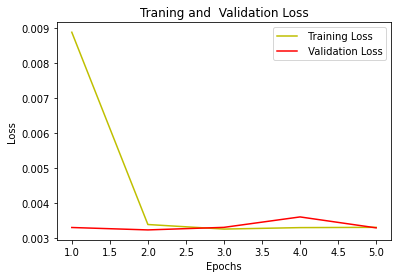

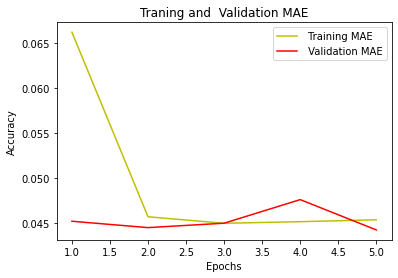

25/25 [==============================] - 1s 7ms/step
MAPE scaled( data both log scaled and normalized ): 19.399278066165188
MAPE linear : 62.975566952192594


In [11]:
history = NN.model_fit(train_x, train_y, epochs=5, batch_size=10, validation_split=0.1)
mape, y_pred = NN.mean_absolute_percentage_error(test_y, test_x, output_delta, output_min)

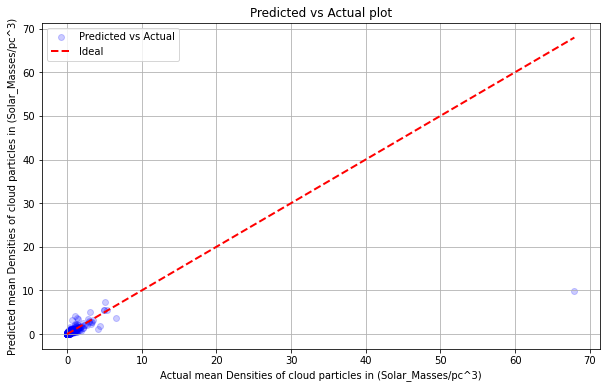

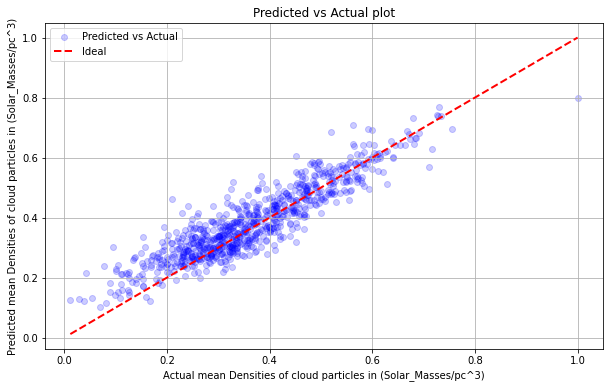

In [12]:
NN.prediction_vs_actual(y_pred, test_y, output_delta, output_min,'Actual mean Densities of cloud particles in (Solar_Masses/pc^3)', 'Predicted mean Densities of cloud particles in (Solar_Masses/pc^3)')
NN.prediction_vs_actual(y_pred, test_y, output_delta, output_min, 'Actual mean Densities of cloud particles in (Solar_Masses/pc^3)', 'Predicted mean Densities of cloud particles in (Solar_Masses/pc^3)',rescale= False)
NN.value_table("3d-model_prediction_file", test_y, y_pred, output_delta, output_min, "Actual 3-D densities", "Predicted 3-d densities") 

In [38]:

NN_models = [
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=4, neuron_array=[8,16,16,8]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=4, neuron_array=[32,64,64,32]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=6, neuron_array=[16,32,32,32,32,16]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=6, neuron_array=[8,16,16,16,16,8]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=6, neuron_array=[32,64,64,64,64,32]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=3, neuron_array=[16,32,16]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=3, neuron_array=[8,16,8]),
    Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100, layers=3, neuron_array=[32,64,32])
]

mape_array = []
mape_array.extend(mape)
for i in range(len(NN_models)):
    history_1 = NN_models[i].model_fit(train_x, train_y, epochs=50, batch_size=10, validation_split=0.1)
    mape_1, y_pred = NN_models[i].mean_absolute_percentage_error(test_y, test_x)
    mape_array.extend(mape_1)

parameter_array= [16,32,64]
layers_array=[4,4,4,6,6,6,3,3,3]                  












NameError: name 'mape' is not defined

In [ ]:
print(mape_array)

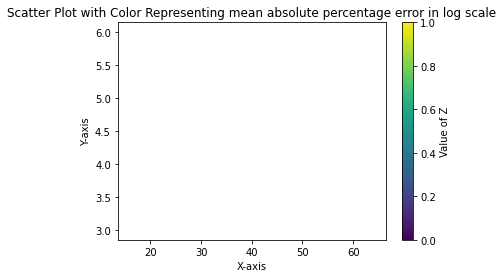

In [39]:
parameter_array= [16,32,64,16,32,64,16,32,64]
layers_array=[4,4,4,6,6,6,3,3,3]   
performance= Model_performance(mape_array,parameter_array,layers_array)
performance.parameter_plot()

MAPE: 12.094642304303793
35/35 [==============================] - 0s 1ms/step
MAPE scaled: 14.78770355071865
MAPE linear : 97.77776704658206
MAPE: 97.77776704658206


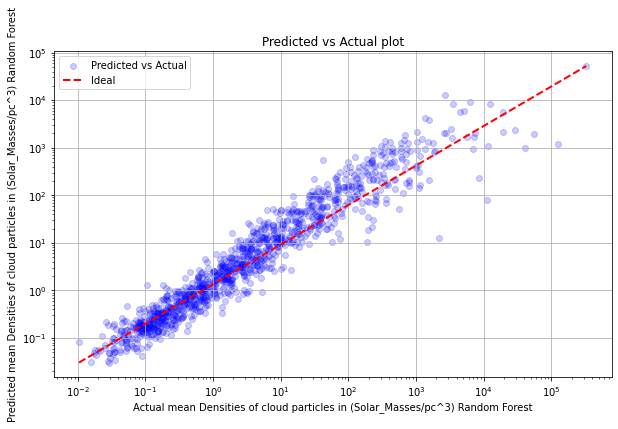

MAPE: 14.78770355071865


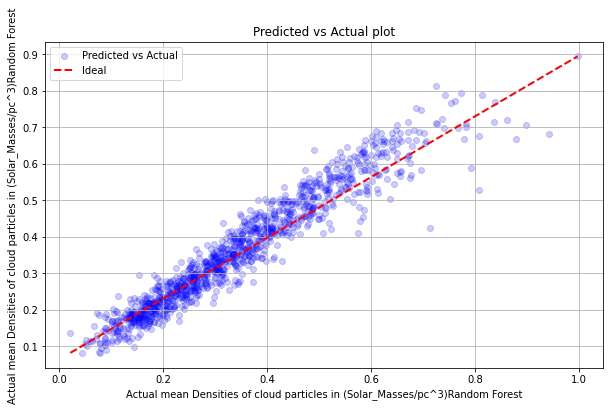

In [53]:
y_pred_rf= NN.Random_forest(test_y=test_y,test_x=test_x)
mape_rf, y_pred_rf = NN.mean_absolute_percentage_error(test_y, test_x, output_delta, output_min)
NN.prediction_vs_actual(y_pred_rf, test_y, output_delta, output_min,'Actual mean Densities of cloud particles in (Solar_Masses/pc^3) Random Forest', 'Predicted mean Densities of cloud particles in (Solar_Masses/pc^3) Random Forest',  scalling= [0, 1e3])
NN.prediction_vs_actual(y_pred_rf, test_y, output_delta, output_min, 'Actual mean Densities of cloud particles in (Solar_Masses/pc^3)Random Forest', 'Predicted mean Densities of cloud particles in (Solar_Masses/pc^3) Random Forest',rescale= False)

In [4]:
# use the newer data to predict the variance and standard deviation 
csv_file = '/home/ajain/cloudphinder/data_all_particles>=100'

df = pd.read_csv(csv_file, sep='\t')
data_array = df.to_numpy()

mean= data_array[0:2132, 5].astype(float).reshape(-1)
variance = data_array[0:2132, 6].astype(float).reshape(-1)
density_2d = data_array[0:2132,0].astype(float).reshape(-1)
dispersion_velocity= data_array[0:2132 ,2].astype(float).reshape(-1)
galacto_centric_distance=  data_array[0:2132, 3].astype(float).reshape(-1)
projected_distance= data_array[0:2132,4].astype(float).reshape(-1)

print(np.mean(variance))
print(np.var(variance))

print(np.min(mean))
print(np.max(mean))

0.8172891198376585
0.05816911872066006
-2.7200356488647617
-0.0570165856524503


In [5]:
density_space_NN = Machine_learning_models(input_dimension=4, output_dimension=1, estimators=100, random_state=100,layers=6, neuron_array=[16,32,32,32,32,16])



log_projection=density_space_NN.log_transformation(projected_distance)
log_density= density_space_NN.log_transformation(density_2d)

transformed_dispersion, dipersion_delta, dispersion_min =  density_space_NN.normalization(dispersion_velocity)
transformed_distance, distance_delta, distance_min =  density_space_NN.normalization(galacto_centric_distance)
transformed_projection, projection_delta, projection_min =  density_space_NN.normalization(log_projection)
transformed_density, density_delta, density_min =  density_space_NN.normalization(log_density)
transformed_mean, mean_delta, mean_min = density_space_NN.normalization(mean)
transformed_variance, variance_delta, variance_min = density_space_NN.normalization(variance)


2024-08-13 14:21:36.380319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cita/modules/python/3.10.2/lib
2024-08-13 14:21:36.380380: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-08-13 14:21:36.380417: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mussel): /proc/driver/nvidia/version does not exist
2024-08-13 14:21:36.380838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
density_mean_NN_input= np.stack((transformed_density, transformed_dispersion, transformed_distance, transformed_projection), axis=1)
density_mean_NN_output= transformed_mean
train_x, test_x, train_y, test_y = train_test_split(density_mean_NN_input, density_mean_NN_output, random_state=0, train_size=0.90)

Epoch 1/10
173/173 [==============================] - 2s 5ms/step - loss: 0.1362 - mean_absolute_error: 0.2569 - val_loss: 0.0228 - val_mean_absolute_error: 0.1209 - lr: 0.0010
Epoch 2/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0214 - mean_absolute_error: 0.1130 - val_loss: 0.0205 - val_mean_absolute_error: 0.1047 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0203 - mean_absolute_error: 0.1076 - val_loss: 0.0203 - val_mean_absolute_error: 0.1008 - lr: 0.0010
Epoch 4/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0202 - mean_absolute_error: 0.1071 - val_loss: 0.0201 - val_mean_absolute_error: 0.1067 - lr: 0.0010
Epoch 5/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.1067 - val_loss: 0.0196 - val_mean_absolute_error: 0.1036 - lr: 0.0010
Epoch 6/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0199 - mean_absolute_error: 0.1064 - va

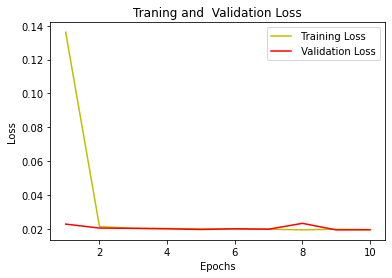

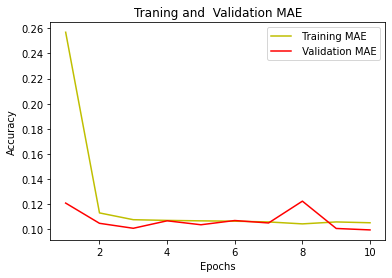

7/7 [==============================] - 0s 2ms/step
MAPE scaled( data only normalized): 13.371288030721335
MAPE linear : 60.88241886915383


In [7]:
history_mean_model = density_space_NN.model_fit(train_x, train_y, epochs=10, batch_size=10, validation_split=0.1)
mape_mean, y_pred_mean= density_space_NN.mean_absolute_percentage_error(test_y, test_x, mean_delta, mean_min, log=False)

this one was executed


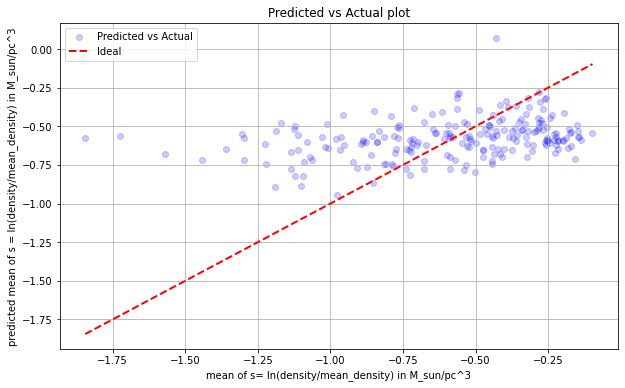

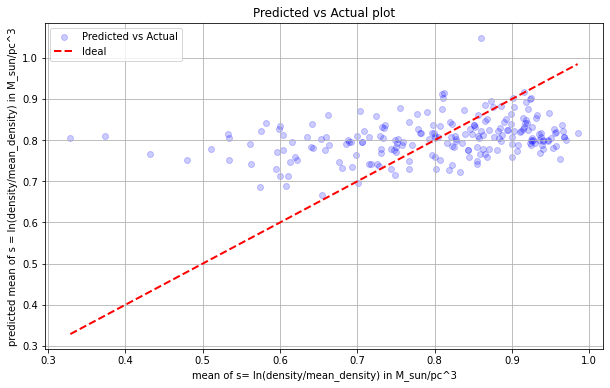

In [8]:
density_space_NN.prediction_vs_actual(y_pred_mean, test_y, mean_delta, mean_min, "mean of s= ln(density/mean_density) in M_sun/pc^3" , "predicted mean of s = ln(density/mean_density) in M_sun/pc^3", rescale= True, log=False)
density_space_NN.prediction_vs_actual(y_pred_mean, test_y, mean_delta, mean_min, "mean of s= ln(density/mean_density) in M_sun/pc^3" , "predicted mean of s = ln(density/mean_density) in M_sun/pc^3", rescale= False)





In [9]:
# variance model analysis
density_mean_NN_input= np.stack((transformed_density, transformed_dispersion, transformed_distance, transformed_projection), axis=1)
density_mean_NN_output= transformed_variance
train_x, test_x, train_y, test_y = train_test_split(density_mean_NN_input, density_mean_NN_output, random_state=0, train_size=0.90)

print(len(np.shape(train_x)))

2


Epoch 1/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0190 - mean_absolute_error: 0.1095 - val_loss: 0.0170 - val_mean_absolute_error: 0.1043 - lr: 1.2158e-04
Epoch 2/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0191 - mean_absolute_error: 0.1094 - val_loss: 0.0170 - val_mean_absolute_error: 0.1049 - lr: 1.2158e-04
Epoch 3/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0190 - mean_absolute_error: 0.1095 - val_loss: 0.0169 - val_mean_absolute_error: 0.1044 - lr: 1.2158e-04
Epoch 4/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0191 - mean_absolute_error: 0.1095 - val_loss: 0.0171 - val_mean_absolute_error: 0.1057 - lr: 1.2158e-04
Epoch 5/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0190 - mean_absolute_error: 0.1097 - val_loss: 0.0170 - val_mean_absolute_error: 0.1039 - lr: 1.2158e-04
Epoch 6/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0191 - mean_absolut

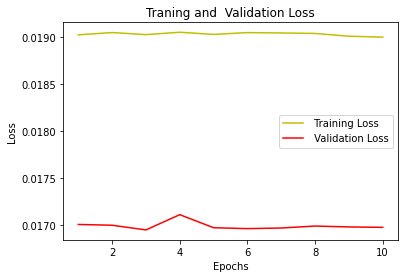

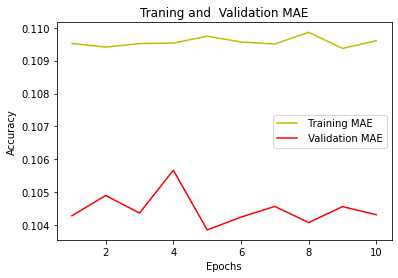

7/7 [==============================] - 0s 1ms/step
MAPE scaled( data both log scaled and normalized ): 43.31550098597779
MAPE linear : 17.97087371544066


In [11]:
 history_var_model = density_space_NN.model_fit(train_x, train_y, epochs=10, batch_size=10, validation_split=0.1)
mape_var, y_pred_var= density_space_NN.mean_absolute_percentage_error(test_y, test_x, variance_delta, variance_min, log= True)



this one was executed


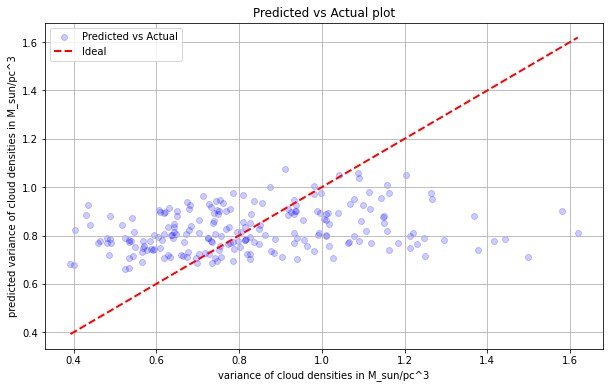

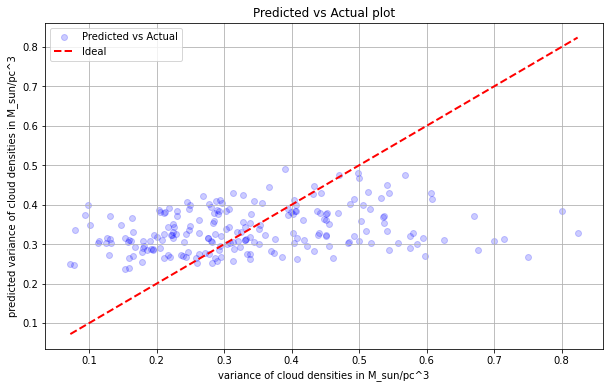

In [12]:
density_space_NN.prediction_vs_actual(y_pred_var, test_y, variance_delta, variance_min,"variance of cloud densities in M_sun/pc^3", "predicted variance of cloud densities in M_sun/pc^3", log=False)
density_space_NN.prediction_vs_actual(y_pred_var, test_y, variance_delta, variance_min,"variance of cloud densities in M_sun/pc^3", "predicted variance of cloud densities in M_sun/pc^3", rescale= False)



In [19]:
#solve the issue of getting multiple outputs from a single NN 
# analyze if the plots of the mean and variance model make sense and are consistent with the original data 
# use the 6 new HDF5 files to get new data and update the plots 
multi_output = Machine_learning_models(input_dimension=4, output_dimension=2, estimators=100, random_state=100, layers=6, neuron_array=[16,32,32,32,32,16])

log_projection=multi_output.log_transformation(projected_distance)
log_density= multi_output.log_transformation(density_2d)


transformed_dispersion, dipersion_delta, dispersion_min =  multi_output.normalization(dispersion_velocity)
transformed_distance, distance_delta, distance_min =  multi_output.normalization(galacto_centric_distance)
transformed_projection, projection_delta, projection_min =  multi_output.normalization(log_projection)
transformed_density, density_delta, density_min =  multi_output.normalization(log_density)
transformed_mean, mean_delta, mean_min = multi_output.normalization(mean)
transformed_variance, variance_delta, variance_min = multi_output.normalization(variance)

                                
                                
                                
                                
                                

In [20]:
NN_input= np.stack((transformed_density, transformed_dispersion, transformed_distance, transformed_projection), axis=1)
NN_output= np.stack((transformed_mean, transformed_variance), axis=-1)
train_x, test_x, train_y, test_y = train_test_split(NN_input, NN_output, random_state=0, train_size=0.90)

print(len(np.shape(train_y)))
print(np.shape(train_x))
print(np.shape(test_y))
print(np.shape(test_x))



2
(1918, 4)
(214, 2)
(214, 4)


Epoch 1/60
173/173 [==============================] - 2s 5ms/step - loss: 0.0587 - mean_absolute_error: 0.1686 - val_loss: 0.0217 - val_mean_absolute_error: 0.1182 - lr: 0.0010
Epoch 2/60
173/173 [==============================] - 1s 5ms/step - loss: 0.0217 - mean_absolute_error: 0.1153 - val_loss: 0.0208 - val_mean_absolute_error: 0.1157 - lr: 0.0010
Epoch 3/60
173/173 [==============================] - 1s 5ms/step - loss: 0.0211 - mean_absolute_error: 0.1128 - val_loss: 0.0202 - val_mean_absolute_error: 0.1120 - lr: 0.0010
Epoch 4/60
173/173 [==============================] - 1s 4ms/step - loss: 0.0205 - mean_absolute_error: 0.1112 - val_loss: 0.0188 - val_mean_absolute_error: 0.1038 - lr: 0.0010
Epoch 5/60
173/173 [==============================] - 1s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.1087 - val_loss: 0.0189 - val_mean_absolute_error: 0.1047 - lr: 0.0010
Epoch 6/60
173/173 [==============================] - 1s 3ms/step - loss: 0.0206 - mean_absolute_error: 0.1106 - va

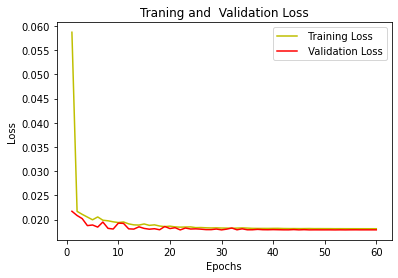

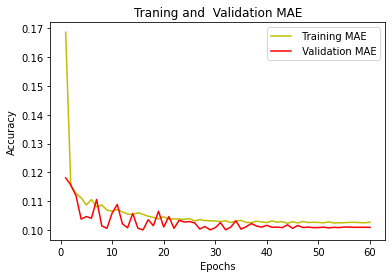

7/7 [==============================] - 0s 2ms/step
MAPE combined scaled( only normalized data ): 28.26860025191192
MAPE combined linear (rescaled to original): 43.245759232034324


In [21]:
delta= list(np.stack((mean_delta, variance_delta), axis=-1))
minima= [mean_min, variance_min]
history_mean_model = multi_output.model_fit(train_x, train_y, epochs=60, batch_size=10, validation_split=0.1)
mape_combied, y_pred_combined= multi_output.mean_absolute_percentage_error(test_y, test_x, delta, minima, log= False)

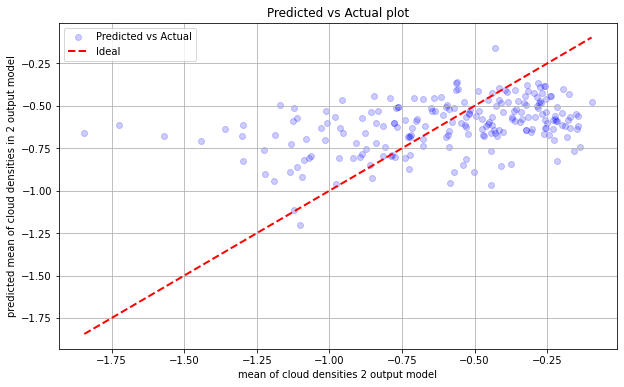

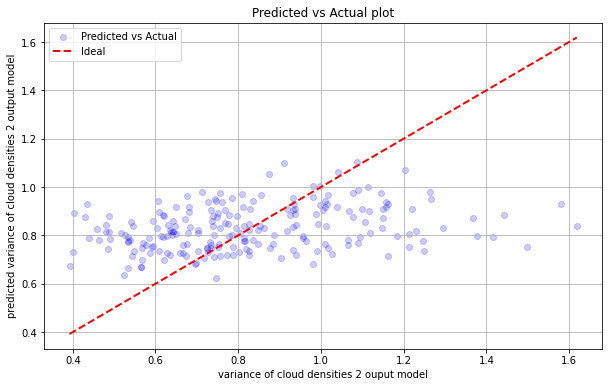

In [22]:
# compare the graphs of predicted vs actual for the combined model and the individual model and see which is better 
multi_output.prediction_vs_actual(y_pred_combined, test_y, delta, minima ,["mean of cloud densities 2 output model", 'variance of cloud densities 2 ouput model'], ["predicted mean of cloud densities in 2 output model", "predicted variance of cloud densities 2 output model"], rescale= True ,log=False)


